# Exercise 1.1: Markov Chain Monte-Carlo of a single polymer

In [26]:
from pathlib import Path

import scipy.interpolate
import numpy as np
import matplotlib.pyplot as plt

import soft_matter.sample

ModuleNotFoundError: No module named 'soft_matter'

In [23]:
NUM_SEGMENTS = 15
SPRING_CONSTANT = 3 * (NUM_SEGMENTS - 1) / 2

np.random.seed(42)  # make experiments reproducible
data_dir = Path.cwd() / ".." / "data"
figure_dir = Path.cwd() / ".." / "report" / "figures"

### Show the fields in the micella

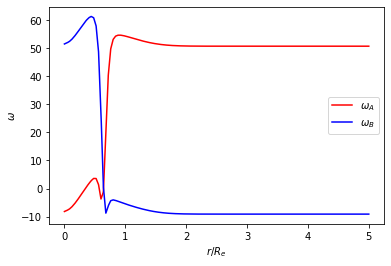

In [24]:
pos, phobic, philic = np.loadtxt(data_dir / "omega.dat", delimiter=" ", skiprows=1, dtype=np.float64).T
field_A = scipy.interpolate.interp1d(pos, phobic, fill_value=phobic[-1], bounds_error=False)
field_B = scipy.interpolate.interp1d(pos, philic, fill_value=philic[-1], bounds_error=False)

r = np.linspace(0, 5, num=1_000)
plt.plot(r, field_A(r), label="$\\omega_A$", color="r")
plt.plot(r, field_B(r), label="$\\omega_B$", color="b")
plt.ylabel("$\\omega$")
plt.xlabel("$r / R_e$")
plt.legend()

In [ ]:
def 
def total_bond_energy(polymer) -> float:
    """Calculate the energy of a polymer stored in it's bonds."""
    diffs = polymer[1:, :] - polymer[:-1, :]
    summed = np.sum(diffs * diffs)
    return summed * SPRING_CONSTANT